In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
import spacy
import collections
import string
import warnings
!pip install advertools
!pip install iterative-stratification
!pip install scikit-multilearn
!pip install indic-nlp-library
from sklearn.metrics import f1_score
import advertools as adv
from indicnlp.tokenize import indic_tokenize  
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore")
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
import advertools as adv
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split  
pd.options.mode.chained_assignment = None
import joblib
warnings.filterwarnings("ignore")


     |████████████████████████████████| 472 kB 5.2 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 254 kB 60.6 MB/s 
     |████████████████████████████████| 65 kB 3.3 MB/s 
     |████████████████████████████████| 3.1 MB 50.7 MB/s 
     |████████████████████████████████| 47 kB 3.9 MB/s 
     |████████████████████████████████| 251 kB 42.6 MB/s 
     |████████████████████████████████| 55 kB 2.7 MB/s 
     |████████████████████████████████| 3.2 MB 50.0 MB/s 
     |████████████████████████████████| 3.6 MB 47.0 MB/s 
     |████████████████████████████████| 74 kB 2.9 MB/s 
  Created wheel for advertools: filename=advertools-0.12.2-py2.py3-none-any.whl size=274315 sha256=e97d82b936f85284892ee418769ca73181e6bd8d83ec2045e55da87700c7e4e0
  Stored in directory: /root/.cache/pip/wheels/22/62/f9/18ae23ba957cc0ac4734a942697a8a3895979b5265b140653f
  Created wheel for protego: fil

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df1 = pd.read_csv('/content/drive/MyDrive/ML project/constraint_Hindi_Train - Sheet1.csv')
df2 = pd.read_csv('/content/drive/MyDrive/ML project/Constraint_Hindi_Valid - Sheet1.csv')
df3 = pd.read_csv('/content/drive/MyDrive/ML project/Test Set Complete - test.csv')
frames = [df1, df2, df3]
df = pd.concat(frames)
index  = range(0,len(df))
df['index'] = index
index = 0
df = df.set_index(['index'])
pd.set_option('display.max_colwidth', None)
df

Unique ID  ...            Labels Set
index             ...                      
0              1  ...        hate,offensive
1              2  ...           non-hostile
2              3  ...           non-hostile
3              4  ...  defamation,offensive
4              5  ...           non-hostile
...          ...  ...                   ...
8187        1649  ...           non-hostile
8188        1650  ...                  hate
8189        1651  ...             offensive
8190        1652  ...           non-hostile
8191        1653  ...           non-hostile

[8192 rows x 3 columns]

In [ ]:
suffixes = {
    1: ["ो", "े", "ू", "ु", "ी", "ि", "ा"],
    2: ["कर", "ाओ", "िए", "ाई", "ाए", "ने", "नी", "ना", "ते", "ीं", "ती", "ता", "ाँ", "ां", "ों", "ें"],
    3: ["ाकर", "ाइए", "ाईं", "ाया", "ेगी", "ेगा", "ोगी", "ोगे", "ाने", "ाना", "ाते", "ाती", "ाता", "तीं", "ाओं", "ाएं", "ुओं", "ुएं", "ुआं"],
    4: ["ाएगी", "ाएगा", "ाओगी", "ाओगे", "एंगी", "ेंगी", "एंगे", "ेंगे", "ूंगी", "ूंगा", "ातीं", "नाओं", "नाएं", "ताओं", "ताएं", "ियाँ", "ियों", "ियां"],
    5: ["ाएंगी", "ाएंगे", "ाऊंगी", "ाऊंगा", "ाइयाँ", "ाइयों", "ाइयां"],
}

def hi_stem(word):
    for L in 5, 4, 3, 2, 1:
        if len(word) > L + 1:
            for suf in suffixes[L]:
                if word.endswith(suf):
                    return word[:-L]
    return word


#Multiple label stratification
def stratification(temp):
  labels = temp['label'].to_list()
  c = collections.Counter(labels)
  sep_labels = []
  for label in labels:
      sep_labels.extend(label.split(','))
  cs = collections.Counter(sep_labels)
  key = {label:i for i,label in enumerate(cs.keys())}
  key
  text_to_category = {label:[] for label in cs.keys()}
  for idx, item in temp.iterrows():
      for label in text_to_category:
          if label in item['label']:
              text_to_category[label].append(1)
          else:
              text_to_category[label].append(0)
  for label in text_to_category:
      temp[label] = text_to_category[label]
  temp = temp.drop(['label'], axis = 1)
  return temp

  # generating stopwords
def gen_stopwords():  
  import re
  stopword=open('/content/drive/MyDrive/Devanagari/final_stopwords.txt','r')
  stop_words=[]
  # pre-process stopword
  for i in stopword:
    i = re.sub('[\n]', '', i)
    stop_words.append(i)
  return stop_words


In [ ]:


def data_pre_processing(df_clean):
  # removing url links
  df_clean.Post = df_clean.Post.apply(lambda x: re.sub(r'https?:\/\/\S+', '', x))
  df_clean.Post = df_clean.Post.apply(lambda x: re.sub(r"www\.[a-z]?\.?(com)+|[a-z]+\.(com)", '', x))
  # removing @mention
  df_clean.Post = df_clean.Post.apply(lambda x: re.sub(r'@[\w]*', '', x))
  # removing all remaining characters that aren't hindi devanagari characters or white space
  df_clean.Post = df_clean.Post.apply(lambda x: re.sub(r"[^ऀ-ॿ\s]", '', x))
  # removing all special characters
  df_clean.Post = df_clean.Post.apply(lambda x: re.sub(r"[`'''`,~,!,@,#,$,%,^,&,*,(,),_,-,+,=,{,[,},},|,\,:,;,\",',<,,,>,.,?,/'''`\n।]", '', x))
  # removing emojis
  emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
  df_clean.Post = df_clean.Post.apply(lambda x: emoji_pattern.sub(r'', x))

  # removing stopwords using spacy advertools 
  stopwords = adv.stopwords['hindi'].union(set(gen_stopwords()))
  df_clean.Post = df_clean.Post.apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords)]))

  # tokenization
  df_clean['tokenized_post'] = df_clean.apply(lambda row:indic_tokenize.trivial_tokenize(row['Post'], lang='hi'), axis=1)
  df_clean.drop(columns=['Post','Unique ID'])

  #Stemming
  df_clean['token'] = df_clean['tokenized_post']#.apply(lambda x: [hi_stem(y) for y in x])
  df_clean.drop(columns=['tokenized_post'])
  df_clean = df_clean[['token', 'Labels Set']]
  df_clean.rename(columns = {'Labels Set':'label'}, inplace = True)

  # Stratification
  df_clean = stratification(df_clean)

  df_clean['sentence']=[" ".join(r) for r in df_clean['token'].values]
  df_clean = df_clean[['token', 'sentence', 'hate', 'offensive', 'non-hostile', 'defamation', 'fake']]
  df_clean.astype({'sentence': 'str'})
  return df_clean




In [ ]:
stopwords = adv.stopwords['hindi'].union(set(gen_stopwords()))
len(stopwords)

334

In [ ]:
df  = data_pre_processing(df)
df

token  ... fake
index                                                                                                                                                                                                            ...     
0                                                                                                                                      [मेरे, देश, हिन्दु, निराले, पक्के, राम, भक्त, बाबर, साले, जय, श्री, राम]  ...    0
1                                                                                                                           [सरकार, हमेशा, किसानों, कमाई, बढ़ाने, नईनई, स्कीमें, लाती, ताकि, आर्थिक, बोझ, पड़े]  ...    0
2                                                                                            [सुशांत, बिजनेस, डील, जून, वो, डील, दीपेश, सुशांत, हत्या, दिन, याद, आई, देखिए, पूछता, भारत, अर्नब, रिपब्लिक, भारत]  ...    0
3                                                                                                    [साले, जेएनयू, छाप, कमिने, लोग, हिन्दुओं, संविधान, सबको, बराबर, अधिकार, देता, सच्चाई, बराबर, अधिकार, देता]  ...    0
4                    [अनलॉक, गाइडलाइन्स, जारी, सितंबर, देशभर, मेट्रो, सेवा, शुरु, होगी, सितंबर, रैलियों, बाकी, फंक्शन, लोगों, इजाजत, कंटेनमेंट, जोन, छूट, सिनेमाहॉल, रहेंगे, वीं, छात्र, सितंबर, स्कूल, सकेंगे]  ...    0
...                                                                                                                                                                                                         ...  ...  ...
8187                                                                                                                [सोनू, सूद, प्रेरणा, आदिवासियों, वो, सरकारें, सकीं, पूरी, स्टोरी, तस्वीर, सोनू, सूदफ़ेसबुक]  ...    0
8188                                                                                                                                         [उमर, खालिद, लगा, दियाकपिल, मिश्रा, शांति, नोबल, पुरस्कार, मिलेगा]  ...    0
8189                                                                                                                                                                                             [पप्पू, कमीना]  ...    0
8190   [मदर, टेरेसा, जीवन, पीड़ितों, सेवा, अर्पित, सौभाग्यशाली, मार्गदर्शन, मुझे, जरूरतमंदों, सेवा, मौका, मिलाउनके, जन्मदिवस, सादर, नमन, जीवन, प्रेरणा, लेते, हमें, देश, लोगों, सेवा, करनी, कोरोना, जान, बचानी]  ...    0
8191                                                                                                    [आईपीएल, कोरोना, डर, रैना, हटने, हरभजन, खेलने, संशय, चेन्नई, सुपरकिंग्स, जोश, हेजलवुड, हालात, फिक्रमंद]  ...    0

[8192 rows x 7 columns]

In [3]:
filename = '/content/drive/MyDrive/ML project/preprocessed_dataset.sav'
# joblib.dump(df, filename)
df = joblib.load(filename)

# **Data Analysis**

In [ ]:
from collections import Counter
df['Length'] = df['token'].str.len()
hate = np.array(df.loc[df['hate'] == 1, 'Length'])
hate = dict(Counter(hate))

offensive = np.array(df.loc[df['offensive'] == 1, 'Length'])
offensive = dict(Counter(offensive))

nonhostile = np.array(df.loc[df['non-hostile'] == 1, 'Length'])
nonhostile = dict(Counter(nonhostile))

defamation = np.array(df.loc[df['defamation'] == 1, 'Length'])
defamation = dict(Counter(defamation))

fake = np.array(df.loc[df['fake'] == 1, 'Length'])
fake = dict(Counter(fake))

2021-12-10 17:59:06,389 | INFO | utils.py:157 | _init_num_threads | NumExpr defaulting to 2 threads.


In [ ]:
import itertools 
temp = dict.fromkeys(range(0,210),0)
temp.update(hate)
hate = dict(itertools.islice(temp.items(), 100)) 

temp = dict.fromkeys(range(0,210),0)
temp.update(offensive)
offensive = dict(itertools.islice(temp.items(), 100)) 

temp = dict.fromkeys(range(0,210),0)
temp.update(nonhostile)
nonhostile = dict(itertools.islice(temp.items(), 100)) 

temp = dict.fromkeys(range(0,210),0)
temp.update(defamation)
defamation = dict(itertools.islice(temp.items(), 100))  

temp = dict.fromkeys(range(0,210),0)
temp.update(fake)
fake = dict(itertools.islice(temp.items(), 100))  


**Length Analysis**

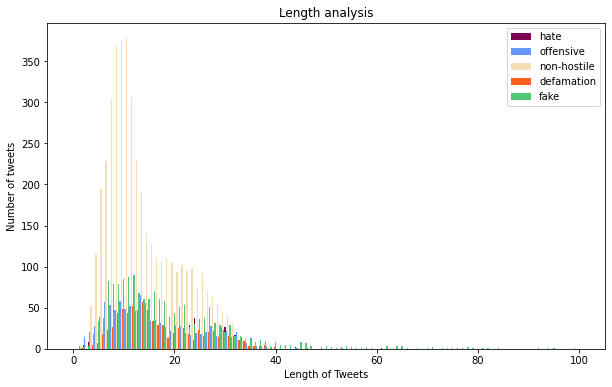

In [ ]:

  
fig = plt.figure(figsize = (10, 6))
 
# creating the bar plot
barWidth = 0.25
br1 = list(hate.keys())
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
br4 = [x + barWidth for x in br3]
br5 = [x + barWidth for x in br4]

plt.bar(br1, list(hate.values()), color ='#7D0552', width = barWidth, label = 'hate')
plt.bar(br2, list(offensive.values()), color ='#6698FF', width = barWidth, label = 'offensive')
plt.bar(br3, list(nonhostile.values()), color ='#F5DEB3', width = barWidth, label = 'non-hostile')
plt.bar(br4, list(defamation.values()), color ='#FF5F1F', width = barWidth, label = 'defamation')
plt.bar(br5, list(fake.values()), color ='#50C878', width = barWidth, label = 'fake')
plt.xlabel("Length of Tweets")
plt.ylabel("Number of tweets")
plt.title("Length analysis")
plt.legend()
plt.show()

**Length Stats**

In [ ]:
hate = df.loc[df['hate'] == 1, 'Length']
offensive = df.loc[df['offensive'] == 1, 'Length']
nonhostile = df.loc[df['non-hostile'] == 1, 'Length']
defamation = df.loc[df['defamation'] == 1, 'Length']
fake = df.loc[df['fake'] == 1, 'Length']


In [ ]:
print("Non_Hostile tweet Length Stats")
print(nonhostile.describe())

Non_Hostile tweet Length Stats
count    4358.000000
mean       13.223726
std         7.090498
min         1.000000
25%         8.000000
50%        11.000000
75%        18.000000
max        38.000000
Name: Length, dtype: float64


**Most frequent words**

In [ ]:
mfw = dict(Counter(" ".join(df["sentence"]).split()).most_common(20))
mfw = sorted(mfw.items(), key=lambda item: item[1], reverse = True)
mfw = dict([(k,v) for v,k in mfw])
mfw

{284: 'दिन',
 287: 'सिंह',
 303: 'लोग',
 305: 'बात',
 307: 'साल',
 323: 'चीन',
 342: 'प्रदेश',
 353: 'दी',
 373: 'नही',
 403: 'श्री',
 418: 'दिल्ली',
 437: 'लोगों',
 463: 'मोदी',
 470: 'पुलिस',
 591: 'सरकार',
 596: 'कोरोना',
 765: 'जी',
 771: 'देश',
 868: 'भारत'}

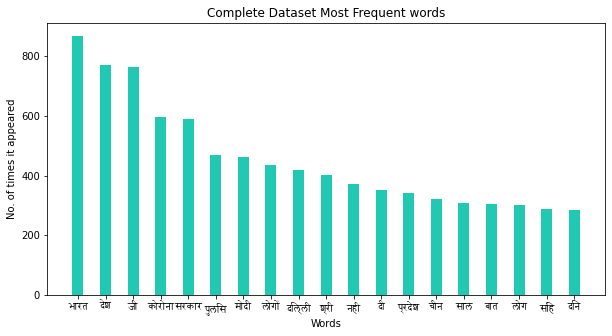

In [ ]:
from matplotlib.font_manager import FontProperties
word = list(mfw.values())
values = list(mfw.keys())
fig = plt.figure(figsize = (10, 5))
hindi_font = FontProperties(fname='/content/drive/MyDrive/Devanagari/chandas1-2.ttf')
# creating the bar plot
xt = plt.subplot()
plt.bar(word, values, color ='#21C9B2', width = 0.4)

for label in (xt.get_xticklabels() + xt.get_yticklabels()):
    label.set_fontproperties(hindi_font)
    label.set_fontsize(10)  

plt.xlabel("Words")
plt.ylabel("No. of times it appeared")
plt.title("Complete Dataset Most Frequent words")
plt.show()

In [ ]:
hate = df.loc[df['hate'] == 1, 'sentence']
offensive = df.loc[df['offensive'] == 1, 'sentence']
nonhostile = df.loc[df['non-hostile'] == 1, 'sentence']
defamation = df.loc[df['defamation'] == 1, 'sentence']
fake = df.loc[df['fake'] == 1, 'sentence']

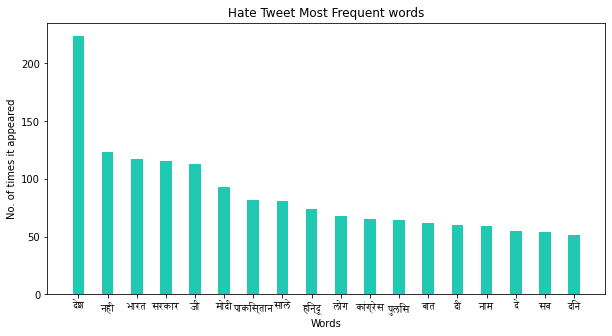

In [ ]:
mfw = dict(Counter(" ".join(hate.iloc[:]).split()).most_common(20))
mfw = sorted(mfw.items(), key=lambda item: item[1], reverse = True)
mfw = dict([(k,v) for v,k in mfw])
mfw1 = mfw

word = list(mfw.values())
values = list(mfw.keys())
fig = plt.figure(figsize = (10, 5))

hindi_font = FontProperties(fname='/content/drive/MyDrive/Devanagari/chandas1-2.ttf')
xt = plt.subplot()
# creating the bar plot
plt.bar(word, values, color ='#21C9B2', width = 0.4)

for label in (xt.get_xticklabels() + xt.get_yticklabels()):
    label.set_fontproperties(hindi_font)
    label.set_fontsize(10)  


plt.xlabel("Words")
plt.ylabel("No. of times it appeared")
plt.title("Hate Tweet Most Frequent words")
plt.show()

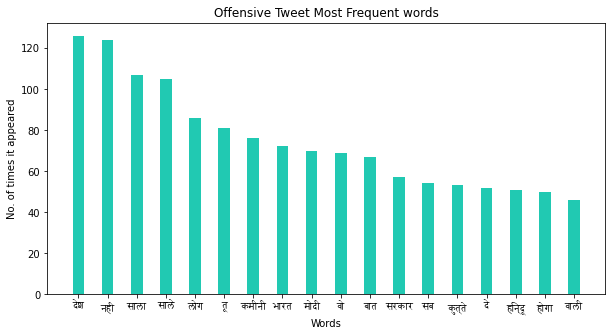

In [ ]:
mfw = dict(Counter(" ".join(offensive.iloc[:]).split()).most_common(20))
mfw = sorted(mfw.items(), key=lambda item: item[1], reverse = True)
mfw = dict([(k,v) for v,k in mfw])
mfw2 = mfw

word = list(mfw.values())
values = list(mfw.keys())
fig = plt.figure(figsize = (10, 5))


hindi_font = FontProperties(fname='/content/drive/MyDrive/Devanagari/chandas1-2.ttf')
xt = plt.subplot()
# creating the bar plot
plt.bar(word, values, color ='#21C9B2', width = 0.4)
for label in (xt.get_xticklabels() + xt.get_yticklabels()):
    label.set_fontproperties(hindi_font)
    label.set_fontsize(10)  


plt.xlabel("Words")
plt.ylabel("No. of times it appeared")
plt.title("Offensive Tweet Most Frequent words")
plt.show()

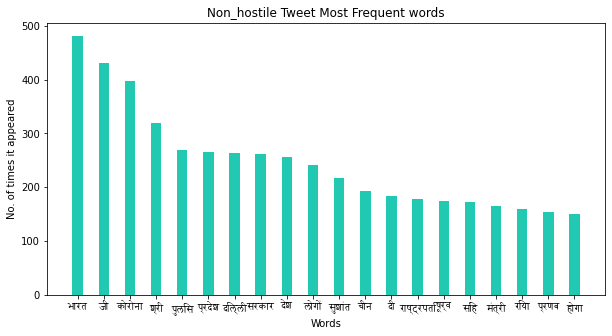

In [ ]:
mfw = dict(Counter(" ".join(nonhostile.iloc[:]).split()).most_common(20))
mfw = sorted(mfw.items(), key=lambda item: item[1], reverse = True)
mfw = dict([(k,v) for v,k in mfw])


word = list(mfw.values())
values = list(mfw.keys())
fig = plt.figure(figsize = (10, 5))
hindi_font = FontProperties(fname='/content/drive/MyDrive/Devanagari/chandas1-2.ttf')
xt = plt.subplot()
# creating the bar plot
plt.bar(word, values, color ='#21C9B2', width = 0.4)

for label in (xt.get_xticklabels() + xt.get_yticklabels()):
    label.set_fontproperties(hindi_font)
    label.set_fontsize(10)  


plt.xlabel("Words")
plt.ylabel("No. of times it appeared")
plt.title("Non_hostile Tweet Most Frequent words")
plt.show()

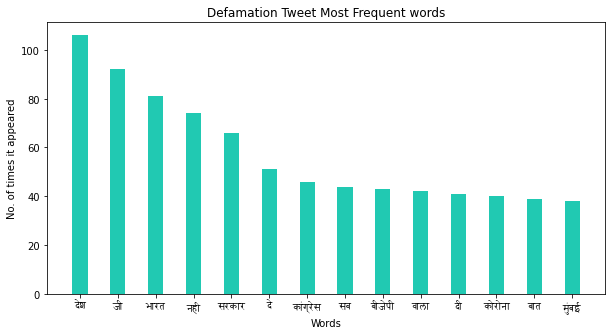

In [ ]:
mfw = dict(Counter(" ".join(defamation.iloc[:]).split()).most_common(20))
mfw = sorted(mfw.items(), key=lambda item: item[1], reverse = True)
mfw = dict([(k,v) for v,k in mfw])
mfw3 = mfw

word = list(mfw.values())
values = list(mfw.keys())
fig = plt.figure(figsize = (10, 5))
hindi_font = FontProperties(fname='/content/drive/MyDrive/Devanagari/chandas1-2.ttf')
xt = plt.subplot()
# creating the bar plot
plt.bar(word, values, color ='#21C9B2', width = 0.4)

for label in (xt.get_xticklabels() + xt.get_yticklabels()):
    label.set_fontproperties(hindi_font)
    label.set_fontsize(10)  


plt.xlabel("Words")
plt.ylabel("No. of times it appeared")
plt.title("Defamation Tweet Most Frequent words")
plt.show()

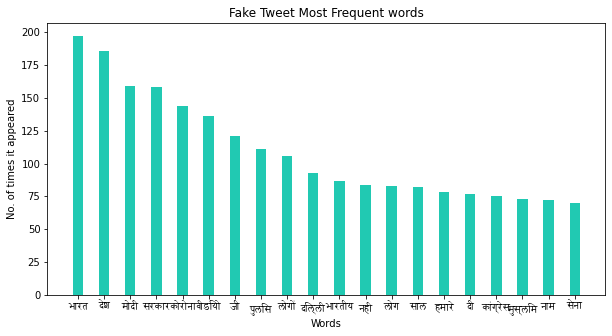

In [ ]:
mfw = dict(Counter(" ".join(fake.iloc[:]).split()).most_common(20))
mfw = sorted(mfw.items(), key=lambda item: item[1], reverse = True)
mfw = dict([(k,v) for v,k in mfw])
mfw4 = mfw

word = list(mfw.values())
values = list(mfw.keys())
fig = plt.figure(figsize = (10, 5))

hindi_font = FontProperties(fname='/content/drive/MyDrive/Devanagari/chandas1-2.ttf')
xt = plt.subplot()
# creating the bar plot
plt.bar(word, values, color ='#21C9B2', width = 0.4)

for label in (xt.get_xticklabels() + xt.get_yticklabels()):
    label.set_fontproperties(hindi_font)
    label.set_fontsize(10)  


plt.xlabel("Words")
plt.ylabel("No. of times it appeared")
plt.title("Fake Tweet Most Frequent words")
plt.show()

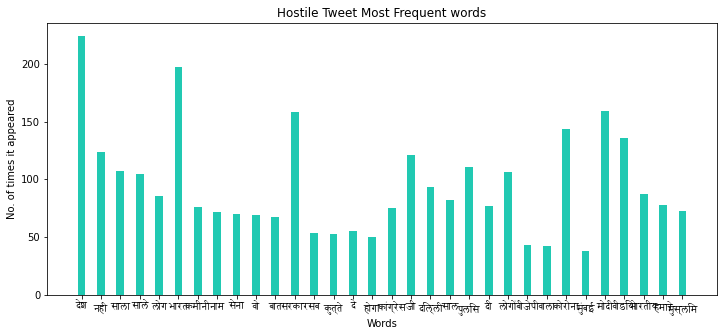

In [ ]:
mfw2.update(mfw1)
mfw2.update(mfw3)
mfw2.update(mfw4)
mfw = mfw2


word = list(mfw.values())
values = list(mfw.keys())
fig = plt.figure(figsize = (12, 5))

hindi_font = FontProperties(fname='/content/drive/MyDrive/Devanagari/chandas1-2.ttf')
xt = plt.subplot()
# creating the bar plot
plt.bar(word, values, color ='#21C9B2', width = 0.4)

for label in (xt.get_xticklabels() + xt.get_yticklabels()):
    label.set_fontproperties(hindi_font)
    label.set_fontsize(10)  


plt.xlabel("Words")
plt.ylabel("No. of times it appeared")
plt.title("Hostile Tweet Most Frequent words")
plt.show()


**Word Cloud**

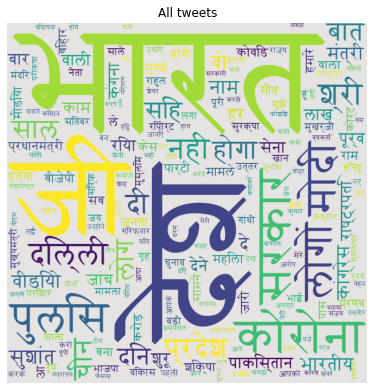

In [ ]:
from wordcloud import WordCloud, STOPWORDS
stopwords = adv.stopwords['hindi'].union(set(gen_stopwords()))
mfw = dict(Counter(" ".join(df["sentence"]).split()).most_common(200))

wordcloud = WordCloud(font_path='/content/drive/MyDrive/Devanagari/chandas1-2.ttf', width = 800, height = 800,
                background_color ='#E5E4E2',
                stopwords = stopwords,
                min_font_size = 10).generate_from_frequencies(frequencies=mfw)
 
# plot the WordCloud image                      
plt.figure(figsize = (5, 5), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.title("All tweets") 
plt.show()

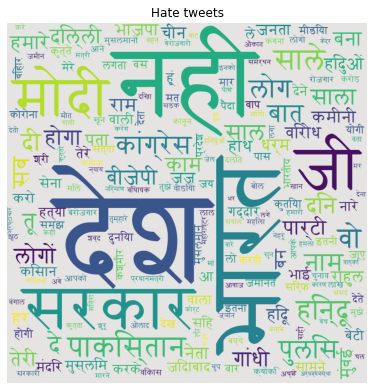

In [ ]:
mfw = dict(Counter(" ".join(hate.iloc[:]).split()).most_common(200))
mfw1 = mfw
wordcloud = WordCloud(font_path='/content/drive/MyDrive/Devanagari/chandas1-2.ttf', width = 800, height = 800,
                background_color ='#E5E4E2',
                stopwords = stopwords,
                min_font_size = 10).generate_from_frequencies(frequencies=mfw)
 
# plot the WordCloud image                      
plt.figure(figsize = (5, 5), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.title("Hate tweets") 
plt.show()

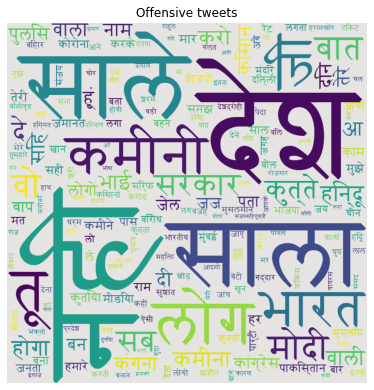

In [ ]:
mfw = dict(Counter(" ".join(offensive.iloc[:]).split()).most_common(200))
mfw1.update(mfw)
wordcloud = WordCloud(font_path='/content/drive/MyDrive/Devanagari/chandas1-2.ttf', width = 800, height = 800,
                background_color ='#E5E4E2',
                stopwords = stopwords,
                min_font_size = 10).generate_from_frequencies(frequencies=mfw)
 
# plot the WordCloud image                      
plt.figure(figsize = (5, 5), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.title("Offensive tweets") 
plt.show()

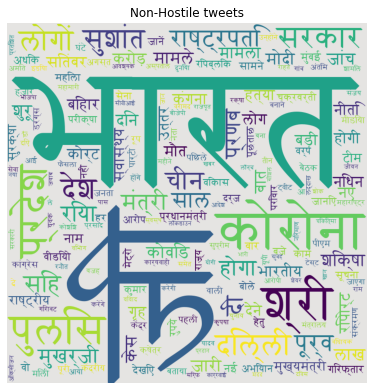

In [ ]:
mfw = dict(Counter(" ".join(nonhostile.iloc[:]).split()).most_common(200))
# mfw1.update(mfw)
wordcloud = WordCloud(font_path='/content/drive/MyDrive/Devanagari/chandas1-2.ttf', width = 800, height = 800,
                background_color ='#E5E4E2',
                stopwords = stopwords,
                min_font_size = 10).generate_from_frequencies(frequencies=mfw)
 
# plot the WordCloud image                      
plt.figure(figsize = (5, 5), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.title("Non-Hostile tweets") 
plt.show()

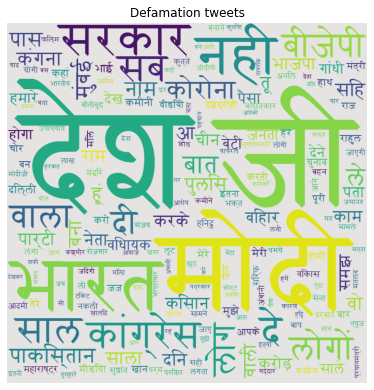

In [ ]:
mfw = dict(Counter(" ".join(defamation.iloc[:]).split()).most_common(200))
mfw1.update(mfw)
wordcloud = WordCloud(font_path='/content/drive/MyDrive/Devanagari/chandas1-2.ttf', width = 800, height = 800,
                background_color ='#E5E4E2',
                stopwords = stopwords,
                min_font_size = 10).generate_from_frequencies(frequencies=mfw)
 
# plot the WordCloud image                      
plt.figure(figsize = (5, 5), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.title("Defamation tweets") 
plt.show()

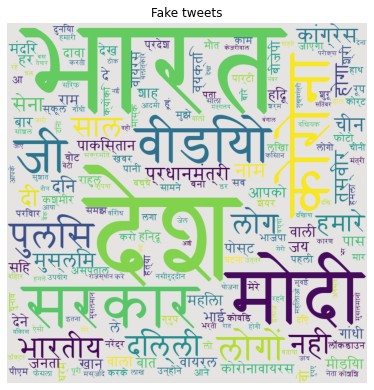

In [ ]:
mfw = dict(Counter(" ".join(fake.iloc[:]).split()).most_common(200))
mfw1.update(mfw)
wordcloud = WordCloud(font_path='/content/drive/MyDrive/Devanagari/chandas1-2.ttf', width = 800, height = 800,
                background_color ='#E5E4E2',
                stopwords = stopwords,
                min_font_size = 10).generate_from_frequencies(frequencies=mfw)
 
# plot the WordCloud image                      
plt.figure(figsize = (5, 5), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.title("Fake tweets") 
plt.show()

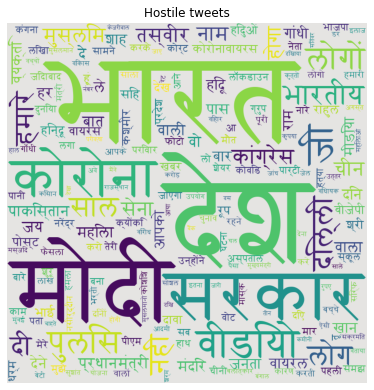

In [ ]:
wordcloud = WordCloud(font_path='/content/drive/MyDrive/Devanagari/chandas1-2.ttf', width = 800, height = 800,
                background_color ='#E5E4E2',
                stopwords = stopwords,
                min_font_size = 10).generate_from_frequencies(frequencies=mfw1)
 
# plot the WordCloud image                      
plt.figure(figsize = (5, 5), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.title("Hostile tweets") 
plt.show()

In [ ]:
# wordcloud = WordCloud(font_path='/content/drive/MyDrive/Devanagari/Lohit-Devanagari.ttf')
# wordcloud.generate_from_frequencies(frequencies=mfw)
# plt.figure()
# plt.imshow(wordcloud, interpolation="bilinear")
# plt.axis("off")
# plt.show()

## **BaseLine Models**

## **TF-idf:**

In [ ]:
y = df[['hate', 'offensive', 'non-hostile', 'defamation', 'fake']]
X = df['sentence']
from sklearn.feature_extraction.text import TfidfVectorizer  
tfidfconverter = TfidfVectorizer(max_features=2000, min_df=2, max_df=0.9)  
X = tfidfconverter.fit_transform(X).toarray()
# X = pd.DataFrame(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)



**Decision Tree:**

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
label = ['hate', 'offensive', 'non-hostile', 'defamation', 'fake']
for l in label:
  y_t1 = y_train[l]
  y_t2 = y_test[l]
  decision_tree = DecisionTreeClassifier(random_state=0, max_depth=15, class_weight='balanced')
  decision_tree = decision_tree.fit(X_train, y_t1)
  predictions = decision_tree.predict(X_test)
  # print(confusion_matrix(y_t2,predictions)) 
  print("For ",l," Tweets: Classification report: \n")
  print(classification_report(y_t2,predictions))  


For  hate  Tweets: Classification report: 

              precision    recall  f1-score   support

           0       0.89      0.85      0.87      1411
           1       0.28      0.36      0.31       228

    accuracy                           0.78      1639
   macro avg       0.58      0.60      0.59      1639
weighted avg       0.81      0.78      0.79      1639

For  offensive  Tweets: Classification report: 

              precision    recall  f1-score   support

           0       0.90      0.92      0.91      1426
           1       0.36      0.29      0.32       213

    accuracy                           0.84      1639
   macro avg       0.63      0.60      0.61      1639
weighted avg       0.83      0.84      0.83      1639

For  non-hostile  Tweets: Classification report: 

              precision    recall  f1-score   support

           0       0.76      0.21      0.33       767
           1       0.58      0.94      0.71       872

    accuracy                          

**Logistic regression:**

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
labels=['hate', 'offensive', 'non-hostile', 'defamation', 'fake']
# Using pipeline for applying logistic regression and one vs rest classifier
LogisticRegression_pipeline = Pipeline([('clf', OneVsRestClassifier(LogisticRegression(class_weight='balanced'), n_jobs=-1)),])
for l in labels:
  y_t1 = y_train[l]
  y_t2 = y_test[l]
  # Training logistic regression model on train data
  LogisticRegression_pipeline.fit(X_train, y_t1)
  
  # calculating test accuracy
  predictions = LogisticRegression_pipeline.predict(X_test)
  print("For ",l," Tweets: Classification report: \n")
  print(classification_report(y_t2,predictions))  

For  hate  Tweets: Classification report: 

              precision    recall  f1-score   support

           0       0.93      0.78      0.84      1411
           1       0.31      0.62      0.41       228

    accuracy                           0.75      1639
   macro avg       0.62      0.70      0.63      1639
weighted avg       0.84      0.75      0.78      1639

For  offensive  Tweets: Classification report: 

              precision    recall  f1-score   support

           0       0.94      0.83      0.88      1426
           1       0.37      0.66      0.47       213

    accuracy                           0.81      1639
   macro avg       0.65      0.75      0.68      1639
weighted avg       0.87      0.81      0.83      1639

For  non-hostile  Tweets: Classification report: 

              precision    recall  f1-score   support

           0       0.72      0.72      0.72       767
           1       0.76      0.76      0.76       872

    accuracy                          

**SVM:**

In [ ]:
from sklearn.svm import SVC
labels=['hate', 'offensive', 'non-hostile', 'defamation', 'fake']
# Using pipeline for applying logistic regression and one vs rest classifier
SVM_pipeline = Pipeline([('clf', OneVsRestClassifier(SVC( kernel = 'rbf' , class_weight='balanced'))),])
for l in labels:
  y_t1 = y_train[l]
  y_t2 = y_test[l]
  # Training logistic regression model on train data
  SVM_pipeline.fit(X_train, y_t1)
  
  # calculating test accuracy
  predictions = SVM_pipeline.predict(X_test)
  print("For ",l," Tweets: Classification report: \n")
  print(classification_report(y_t2,predictions))  

For  hate  Tweets: Classification report: 

              precision    recall  f1-score   support

           0       0.90      0.92      0.91      1411
           1       0.42      0.37      0.40       228

    accuracy                           0.84      1639
   macro avg       0.66      0.65      0.65      1639
weighted avg       0.83      0.84      0.84      1639

For  offensive  Tweets: Classification report: 

              precision    recall  f1-score   support

           0       0.91      0.94      0.93      1426
           1       0.50      0.40      0.45       213

    accuracy                           0.87      1639
   macro avg       0.71      0.67      0.69      1639
weighted avg       0.86      0.87      0.86      1639

For  non-hostile  Tweets: Classification report: 

              precision    recall  f1-score   support

           0       0.75      0.73      0.74       767
           1       0.77      0.79      0.78       872

    accuracy                          

# **Count Vectorizer:**

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
X = df['sentence']
y_cv = df[['hate', 'offensive', 'non-hostile', 'defamation', 'fake']]
# Create our vectorizer
vectorizer = CountVectorizer(max_features=3000,min_df=2, max_df=0.8)
# Create the vectorizer
x_vectors = vectorizer.fit_transform(X).toarray()
x_df = pd.DataFrame(x_vectors)
Xcv_train, Xcv_test, ycv_train, ycv_test = train_test_split(x_df, y_cv, test_size=0.2, stratify=y)

**Decision Tree:**

In [ ]:
label = ['hate', 'offensive', 'non-hostile', 'defamation', 'fake']
for l in label:
  y_t1 = ycv_train[l]
  y_t2 = ycv_test[l]
  decision_tree = DecisionTreeClassifier(random_state=0, max_depth=15, class_weight='balanced')
  decision_tree = decision_tree.fit(Xcv_train, y_t1)
  predictions = decision_tree.predict(Xcv_test)
  # print(confusion_matrix(y_t2,predictions)) 
  print("For ",l," Tweets: Classification report: \n")
  print(classification_report(y_t2,predictions))  

For  hate  Tweets: Classification report: 

              precision    recall  f1-score   support

           0       0.91      0.80      0.85      1411
           1       0.28      0.48      0.36       228

    accuracy                           0.76      1639
   macro avg       0.59      0.64      0.60      1639
weighted avg       0.82      0.76      0.78      1639

For  offensive  Tweets: Classification report: 

              precision    recall  f1-score   support

           0       0.91      0.90      0.90      1426
           1       0.37      0.37      0.37       213

    accuracy                           0.83      1639
   macro avg       0.64      0.64      0.64      1639
weighted avg       0.84      0.83      0.84      1639

For  non-hostile  Tweets: Classification report: 

              precision    recall  f1-score   support

           0       0.83      0.27      0.41       767
           1       0.60      0.95      0.73       872

    accuracy                          

**Logistic Regression:**

In [ ]:

labels=['hate', 'offensive', 'non-hostile', 'defamation', 'fake']
# Using pipeline for applying logistic regression and one vs rest classifier
LogisticRegression_pipeline = Pipeline([('clf', OneVsRestClassifier(LogisticRegression(class_weight='balanced'), n_jobs=-1)),])
for l in labels:
  y_t1 = ycv_train[l]
  y_t2 = ycv_test[l]
  # Training logistic regression model on train data
  LogisticRegression_pipeline.fit(Xcv_train, y_t1)
  
  # calculating test accuracy
  predictions = LogisticRegression_pipeline.predict(Xcv_test)
  print("For ",l," Tweets: Classification report: \n")
  print(classification_report(y_t2,predictions))  

For  hate  Tweets: Classification report: 

              precision    recall  f1-score   support

           0       0.92      0.80      0.85      1411
           1       0.31      0.57      0.40       228

    accuracy                           0.76      1639
   macro avg       0.62      0.68      0.63      1639
weighted avg       0.84      0.76      0.79      1639

For  offensive  Tweets: Classification report: 

              precision    recall  f1-score   support

           0       0.93      0.81      0.87      1426
           1       0.31      0.57      0.40       213

    accuracy                           0.78      1639
   macro avg       0.62      0.69      0.64      1639
weighted avg       0.85      0.78      0.81      1639

For  non-hostile  Tweets: Classification report: 

              precision    recall  f1-score   support

           0       0.75      0.74      0.74       767
           1       0.77      0.78      0.78       872

    accuracy                          

**SVM:**

In [ ]:

labels=['hate', 'offensive', 'non-hostile', 'defamation', 'fake']
# Using pipeline for applying logistic regression and one vs rest classifier
SVM_pipeline = Pipeline([('clf', OneVsRestClassifier(SVC(class_weight='balanced'))),])
for l in labels:
  y_t1 = ycv_train[l]
  y_t2 = ycv_test[l]
  # Training logistic regression model on train data
  SVM_pipeline.fit(Xcv_train, y_t1)
  
  # calculating test accuracy
  predictions = SVM_pipeline.predict(Xcv_test)
  print("For ",l," Tweets: Classification report: \n")
  print(classification_report(y_t2,predictions))

For  hate  Tweets: Classification report: 

              precision    recall  f1-score   support

           0       0.91      0.90      0.91      1411
           1       0.42      0.45      0.43       228

    accuracy                           0.84      1639
   macro avg       0.67      0.67      0.67      1639
weighted avg       0.84      0.84      0.84      1639

For  offensive  Tweets: Classification report: 

              precision    recall  f1-score   support

           0       0.91      0.90      0.91      1426
           1       0.40      0.44      0.42       213

    accuracy                           0.84      1639
   macro avg       0.66      0.67      0.66      1639
weighted avg       0.85      0.84      0.84      1639

For  non-hostile  Tweets: Classification report: 

              precision    recall  f1-score   support

           0       0.76      0.76      0.76       767
           1       0.79      0.79      0.79       872

    accuracy                          

# **After MidSem:**

# **RNN:**

In [ ]:
def RNN_Embedding():
  s=df['token'].to_list()
  words = [item for sublist in s for item in sublist]
  # so that all duplicate words are removed
  words = set(words)
  print(words)
  unique_word_count = len(words)
  sen=df['sentence'].to_list()
  sen=df['sentence'].to_list()
  len(sen)
  from keras.preprocessing.text import one_hot
  vocab_size=unique_word_count

  encoded_docs=[one_hot(d,vocab_size) for d in sen]

  from keras.preprocessing.sequence import pad_sequences
  from keras.models import Sequential
  from keras.layers import Embedding
  from keras.layers import Flatten
  from keras.layers import Dense

  import numpy as np

  embedding_length=5
  max_length=10

  encoded_docs=pad_sequences(encoded_docs,truncating='post',padding='post',maxlen=max_length)
  print(encoded_docs)


  # define the model
  model = Sequential()
  model.add(Embedding(vocab_size, embedding_length, input_length=max_length))
  model.add(Flatten())
  model.add(Dense(1, activation='sigmoid'))
  # compile the model
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  # summarize the model
  print(model.summary())
  output=model.predict(encoded_docs)
  return output

In [ ]:
output=RNN_Embedding()

{'', 'द्रविड़', 'कुते', 'भुगतना', 'रिहाई', 'टिक्की', 'लिखी', 'उपमुख्यमंत्री', 'आरोपित', 'टासुकूहोंजो', 'दोस्तों', 'दस', 'उठोगे', 'गर्क', 'पजामा', 'हवेली', 'कितनी', 'बधाईयह', 'कलिता', 'उजागर', 'कियाहमने', 'नमाजवादीपार्टी', 'उठाकर', 'चायसमोसे', 'खुराक', 'विस्फोट', 'रुख', 'बदलते', 'लिब्रेशन', 'सेनापति', 'फिक्सशाहीन', 'कण्ट्रोल', 'रिवॉल्वर', 'लगीं', 'जबरदस्त', 'झुमका', 'इंस्पेक्टर', 'गलती', 'खिलौनों', 'किच्चा', 'जीतें', 'चाहिएन', 'सत्याग्रह', 'ढूंढ', 'दूरबीनों', 'हैकौन', 'गुनी', 'जूं', 'हौज़', 'रामविलास', 'राज्यपाल', 'ख़बर', 'लबादा', 'विपक्ष', 'फ़ोटोग्राफ़', 'भड़काने', 'निष्पक्ष', 'फैलाए', 'फूटफूट', 'वकास', 'परिचित', 'किसान', 'उकलाना', 'डबल', 'संग्रहअगस्त', 'चाहिएसुवरआज़मखान', 'रफ़ाल', 'थाक्योंकि', 'समाधि', 'मारूँ', 'खड़े', 'हैंशिक्षा', 'जियोनी', 'आश्चर्यचकित', 'होताकुछ', 'शिविर', 'पीटने', 'गैरयौगिक', 'खिलाफमहाप्रदर्शन', 'फारूक', 'मौलिक', 'हज़ार', 'कहे', 'शाखाएं', 'हैइधर', 'सराहनीय', 'वाहवाही', 'पकड़ाया', 'विवादित', 'फील', 'रत्नपूर्व', 'अल्लाह', 'निपटती', 'पाएगाआप', 'अनुरूप', 'लिचिंग', 'त्वरि

In [ ]:
y = df[['hate', 'offensive', 'non-hostile', 'defamation', 'fake']] 
X_train, X_test, y_train, y_test = train_test_split(output, y, test_size=0.2, stratify=y)

**Decision Tree:**

In [ ]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.tree import DecisionTreeClassifier
LR = OneVsRestClassifier(DecisionTreeClassifier(class_weight='balanced'), n_jobs=1)
categories=['hate', 'offensive', 'non-hostile', 'defamation', 'fake']
for category in categories:
    print('... Processing {}'.format(category))
    # train the model using X_dtm & y
    LR.fit(X_train, y_train[category])
    # compute the testing accuracy
    prediction = LR.predict(X_test)
    print("For ",category," Tweets: Classification report: \n")
    print(classification_report(y_test[category],prediction))

... Processing hate
For  hate  Tweets: Classification report: 

              precision    recall  f1-score   support

           0       0.87      0.86      0.87      1411
           1       0.17      0.18      0.17       228

    accuracy                           0.77      1639
   macro avg       0.52      0.52      0.52      1639
weighted avg       0.77      0.77      0.77      1639

... Processing offensive
For  offensive  Tweets: Classification report: 

              precision    recall  f1-score   support

           0       0.87      0.89      0.88      1426
           1       0.16      0.13      0.14       213

    accuracy                           0.79      1639
   macro avg       0.51      0.51      0.51      1639
weighted avg       0.78      0.79      0.79      1639

... Processing non-hostile
For  non-hostile  Tweets: Classification report: 

              precision    recall  f1-score   support

           0       0.48      0.48      0.48       767
           1       0.

**Logistic Regression:**

In [ ]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
LR = OneVsRestClassifier(LogisticRegression(class_weight='balanced'), n_jobs=1)
categories=['hate', 'offensive', 'non-hostile', 'defamation', 'fake']
for category in categories:
    print('... Processing {}'.format(category))
    # train the model using X_dtm & y
    LR.fit(X_train, y_train[category])
    # compute the testing accuracy
    prediction = LR.predict(X_test)
    print("For ",category," Tweets: Classification report: \n")
    print(classification_report(y_test[category],prediction))


... Processing hate
For  hate  Tweets: Classification report: 

              precision    recall  f1-score   support

           0       0.88      0.51      0.65      1411
           1       0.16      0.56      0.25       228

    accuracy                           0.52      1639
   macro avg       0.52      0.54      0.45      1639
weighted avg       0.78      0.52      0.59      1639

... Processing offensive
For  offensive  Tweets: Classification report: 

              precision    recall  f1-score   support

           0       0.88      0.51      0.65      1426
           1       0.14      0.51      0.21       213

    accuracy                           0.51      1639
   macro avg       0.51      0.51      0.43      1639
weighted avg       0.78      0.51      0.59      1639

... Processing non-hostile
For  non-hostile  Tweets: Classification report: 

              precision    recall  f1-score   support

           0       0.49      0.53      0.51       767
           1       0.

**SVM:**

In [ ]:
from sklearn.svm import SVC
labels=['hate', 'offensive', 'non-hostile', 'defamation', 'fake']
SVM_pipeline = Pipeline([('clf', OneVsRestClassifier(SVC( kernel = 'rbf' , class_weight='balanced'))),])
for l in labels:
  y_t1 = y_train[l]
  y_t2 = y_test[l]
  SVM_pipeline.fit(X_train, y_t1)

  predictions = SVM_pipeline.predict(X_test)
  print("For ",l," Tweets: Classification report: \n")
  print(classification_report(y_t2,predictions))  

For  hate  Tweets: Classification report: 

              precision    recall  f1-score   support

           0       0.88      0.51      0.65      1411
           1       0.16      0.58      0.25       228

    accuracy                           0.52      1639
   macro avg       0.52      0.54      0.45      1639
weighted avg       0.78      0.52      0.59      1639

For  offensive  Tweets: Classification report: 

              precision    recall  f1-score   support

           0       0.88      0.51      0.65      1426
           1       0.14      0.51      0.21       213

    accuracy                           0.51      1639
   macro avg       0.51      0.51      0.43      1639
weighted avg       0.78      0.51      0.59      1639

For  non-hostile  Tweets: Classification report: 

              precision    recall  f1-score   support

           0       0.47      0.65      0.55       767
           1       0.54      0.37      0.44       872

    accuracy                          

**Random Forest Classifier:**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
LR = OneVsRestClassifier(RandomForestClassifier(class_weight='balanced'), n_jobs=1)
categories=['hate', 'offensive', 'non-hostile', 'defamation', 'fake']
for category in categories:
    print('... Processing {}'.format(category))
    LR.fit(X_train, y_train[category])
    prediction = LR.predict(X_test)
    print("For ",category," Tweets: Classification report: \n")
    print(classification_report(y_test[category],prediction))

... Processing hate
For  hate  Tweets: Classification report: 

              precision    recall  f1-score   support

           0       0.86      0.86      0.86      1411
           1       0.15      0.16      0.16       228

    accuracy                           0.76      1639
   macro avg       0.51      0.51      0.51      1639
weighted avg       0.76      0.76      0.76      1639

... Processing offensive
For  offensive  Tweets: Classification report: 

              precision    recall  f1-score   support

           0       0.88      0.88      0.88      1426
           1       0.19      0.20      0.19       213

    accuracy                           0.79      1639
   macro avg       0.54      0.54      0.54      1639
weighted avg       0.79      0.79      0.79      1639

... Processing non-hostile
For  non-hostile  Tweets: Classification report: 

              precision    recall  f1-score   support

           0       0.49      0.50      0.49       767
           1       0.

**Bar Graph**

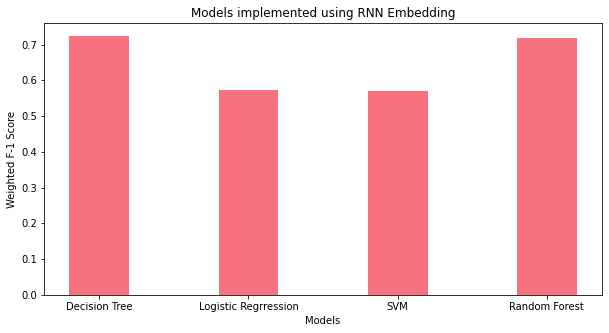

In [7]:
scores = [0.724, 0.572, 0.570, 0.718]
models = ['Decision Tree', 'Logistic Regrression', 'SVM', 'Random Forest']
fig = plt.figure(figsize = (10, 5))
xt = plt.subplot()
# creating the bar plot
plt.bar(models, scores, color ='#F67280', width = 0.4)
plt.xlabel("Models")
plt.ylabel("Weighted F-1 Score")
plt.title("Models implemented using RNN Embedding")
plt.show()

# **WORD2VEC EMBEDDING GENSIM**

In [ ]:
def avg_word_vector(word2vec_model, words):

    words = [word for word in words if word in word2vec_model.wv.vocab]
    if len(words) >= 1:
        return np.mean(word2vec_model[words], axis=0)
    else:
        return []

In [ ]:
def GensimEmbedding():
    reviews=df['token'].to_list()
    print(reviews)

    for i in range(5):
        print(reviews[i])

    all_tokens = [item for sublist in reviews for item in sublist]
    import gensim 
    model = gensim.models.Word2Vec(reviews)
    model.train(reviews,total_examples=len(reviews),epochs=10)
    for i in range(3):
        print("word vector for the word: '" + reviews[0][i] + "'")
        print(model.wv[reviews[0][i]])
        print('\n')

    review_vector=[]
    for i in range(len(reviews)):
        review_vector.append(avg_word_vector(model,reviews[i]))

    for i in range(3):
        print("vector for review {}".format(i))
        print(review_vector[i])
        print("\n")

    rv = pd.DataFrame(review_vector)
    print(rv)
    rv = rv.replace(np.nan, 0)
    return rv


In [ ]:
rv=GensimEmbedding()

[['मेरे', 'देश', 'हिन्दु', 'निराले', 'पक्के', 'राम', 'भक्त', 'बाबर', 'साले', 'जय', 'श्री', 'राम'], ['सरकार', 'हमेशा', 'किसानों', 'कमाई', 'बढ़ाने', 'नईनई', 'स्कीमें', 'लाती', 'ताकि', 'आर्थिक', 'बोझ', 'पड़े'], ['सुशांत', 'बिजनेस', 'डील', 'जून', 'वो', 'डील', 'दीपेश', 'सुशांत', 'हत्या', 'दिन', 'याद', 'आई', 'देखिए', 'पूछता', 'भारत', 'अर्नब', 'रिपब्लिक', 'भारत'], ['साले', 'जेएनयू', 'छाप', 'कमिने', 'लोग', 'हिन्दुओं', 'संविधान', 'सबको', 'बराबर', 'अधिकार', 'देता', 'सच्चाई', 'बराबर', 'अधिकार', 'देता'], ['अनलॉक', 'गाइडलाइन्स', 'जारी', 'सितंबर', 'देशभर', 'मेट्रो', 'सेवा', 'शुरु', 'होगी', 'सितंबर', 'रैलियों', 'बाकी', 'फंक्शन', 'लोगों', 'इजाजत', 'कंटेनमेंट', 'जोन', 'छूट', 'सिनेमाहॉल', 'रहेंगे', 'वीं', 'छात्र', 'सितंबर', 'स्कूल', 'सकेंगे'], ['चीन', 'तर्क', 'भारत', 'विपक्ष', 'अजर', 'मसुद', 'आतंकी', 'मानता', 'माने', 'चुल्लू', 'भर', 'मूत्र', 'डूब', 'मरो', 'गद्दारों', 'भारत', 'लोगों', 'सोचना', 'वो', 'विपक्ष', 'वोट', 'करेंविक्रम', 'शर्मा'], ['देश', 'रिकॉर्ड', 'मामले'], ['निकले', 'सुन', 'बाकी', 'छात्रों', 

2021-12-10 19:30:06,758 | INFO | textcleaner.py:37 | <module> | 'pattern' package not found; tag filters are not available for English
2021-12-10 19:30:06,772 | INFO | word2vec.py:1567 | scan_vocab | collecting all words and their counts
2021-12-10 19:30:06,775 | INFO | word2vec.py:1552 | _scan_vocab | PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2021-12-10 19:30:06,868 | INFO | word2vec.py:1575 | scan_vocab | collected 21128 word types from a corpus of 122255 raw words and 8192 sentences
2021-12-10 19:30:06,871 | INFO | word2vec.py:1626 | prepare_vocab | Loading a fresh vocabulary
2021-12-10 19:30:06,909 | INFO | word2vec.py:1650 | prepare_vocab | effective_min_count=5 retains 4432 unique words (20% of original 21128, drops 16696)
2021-12-10 19:30:06,913 | INFO | word2vec.py:1656 | prepare_vocab | effective_min_count=5 leaves 96987 word corpus (79% of original 122255, drops 25268)
2021-12-10 19:30:06,946 | INFO | word2vec.py:1715 | prepare_vocab | deleting the raw

word vector for the word: 'मेरे'
[ 0.4484802  -0.5991299   0.2038648   0.41049483 -0.44864494  0.5703084
  0.05854711 -0.04001187  0.33381888  0.27119017  0.38221154 -0.01037199
  0.15357114  0.03168293 -0.34990597 -0.6868672   0.00175457 -0.45237184
  0.45602217 -0.47754246 -0.16710924 -0.1425682   0.0619826   0.56520236
  0.05616442  0.3038823  -0.32157558  0.11815857  0.21900217  0.22748615
 -0.21111912  0.29001078 -0.7305782   0.45660856  0.40681416  0.56531966
 -0.81317234 -0.48559982  0.2999793   0.928058    0.34804377  0.0469095
  0.1886914  -0.28281945 -0.5394738  -0.10672208  0.12331894  0.06312166
 -0.2068646  -0.14864524 -0.04387372  0.10571209 -0.02238221  0.4602817
  0.06328468  0.1309358   0.06581327 -0.6907166  -0.3684384   0.10148594
  0.08431192 -0.99392676  0.31234223  0.09029467  0.20069854  0.10140628
  0.7923392   0.19648825  0.01767532  0.27105176  0.30087933  0.06350035
  0.14935824 -0.45259345  0.25882697 -0.04948847 -0.54484046 -0.2774488
  0.2673372   0.352374

In [ ]:
y = df[['hate', 'offensive', 'non-hostile', 'defamation', 'fake']] 
X_train,X_test, y_train, y_test = train_test_split(rv, y, test_size=0.2, stratify=y)

**Decision Tree:**

In [ ]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.tree import DecisionTreeClassifier
LR = OneVsRestClassifier(DecisionTreeClassifier(class_weight='balanced'), n_jobs=1)
categories=['hate', 'offensive', 'non-hostile', 'defamation', 'fake']
for category in categories:
    print('... Processing {}'.format(category))
    # train the model using X_dtm & y
    LR.fit(X_train, y_train[category])
    # compute the testing accuracy
    prediction = LR.predict(X_test)
    print("For ",category," Tweets: Classification report: \n")
    print(classification_report(y_test[category],prediction))

... Processing hate
For  hate  Tweets: Classification report: 

              precision    recall  f1-score   support

           0       0.88      0.90      0.89      1411
           1       0.29      0.27      0.28       228

    accuracy                           0.81      1639
   macro avg       0.59      0.58      0.59      1639
weighted avg       0.80      0.81      0.81      1639

... Processing offensive
For  offensive  Tweets: Classification report: 

              precision    recall  f1-score   support

           0       0.90      0.91      0.91      1426
           1       0.37      0.36      0.36       213

    accuracy                           0.84      1639
   macro avg       0.64      0.63      0.64      1639
weighted avg       0.84      0.84      0.84      1639

... Processing non-hostile
For  non-hostile  Tweets: Classification report: 

              precision    recall  f1-score   support

           0       0.72      0.73      0.72       767
           1       0.

**Logistic Regression:**

In [ ]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
LR = OneVsRestClassifier(LogisticRegression(class_weight='balanced'), n_jobs=1)
categories=['hate', 'offensive', 'non-hostile', 'defamation', 'fake']
for category in categories:
    print('... Processing {}'.format(category))
    # train the model using X_dtm & y
    LR.fit(X_train, y_train[category])
    # compute the testing accuracy
    prediction = LR.predict(X_test)
    print("For ",category," Tweets: Classification report: \n")
    print(classification_report(y_test[category],prediction))

... Processing hate
For  hate  Tweets: Classification report: 

              precision    recall  f1-score   support

           0       0.95      0.73      0.82      1411
           1       0.31      0.75      0.44       228

    accuracy                           0.73      1639
   macro avg       0.63      0.74      0.63      1639
weighted avg       0.86      0.73      0.77      1639

... Processing offensive
For  offensive  Tweets: Classification report: 

              precision    recall  f1-score   support

           0       0.96      0.78      0.86      1426
           1       0.35      0.80      0.49       213

    accuracy                           0.78      1639
   macro avg       0.66      0.79      0.68      1639
weighted avg       0.88      0.78      0.81      1639

... Processing non-hostile
For  non-hostile  Tweets: Classification report: 

              precision    recall  f1-score   support

           0       0.78      0.77      0.77       767
           1       0.

**SVM:**

In [ ]:
SVC = OneVsRestClassifier(LinearSVC(class_weight='balanced'), n_jobs=1)
categories=['hate', 'offensive', 'non-hostile', 'defamation', 'fake']
for category in categories:
    # train the model using X_dtm & y
    SVC.fit(X_train, y_train[category])
    # compute the testing accuracy
    print("For ",category," Tweets: Classification report: \n")
    print(classification_report(y_test[category],prediction))


For  hate  Tweets: Classification report: 

              precision    recall  f1-score   support

           0       0.86      0.98      0.91      1411
           1       0.06      0.01      0.02       228

    accuracy                           0.84      1639
   macro avg       0.46      0.49      0.46      1639
weighted avg       0.75      0.84      0.79      1639

For  offensive  Tweets: Classification report: 

              precision    recall  f1-score   support

           0       0.87      0.98      0.92      1426
           1       0.11      0.02      0.03       213

    accuracy                           0.85      1639
   macro avg       0.49      0.50      0.48      1639
weighted avg       0.77      0.85      0.81      1639

For  non-hostile  Tweets: Classification report: 

              precision    recall  f1-score   support

           0       0.46      0.96      0.62       767
           1       0.23      0.01      0.02       872

    accuracy                          

**Random Forest Classifier:**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
LR = OneVsRestClassifier(RandomForestClassifier(class_weight='balanced'), n_jobs=1)
categories=['hate', 'offensive', 'non-hostile', 'defamation', 'fake']
for category in categories:
    print('... Processing {}'.format(category))
    # train the model using X_dtm & y
    LR.fit(X_train, y_train[category])
    # compute the testing accuracy
    prediction = LR.predict(X_test)
    print("For ",category," Tweets: Classification report: \n")
    print(classification_report(y_test[category],prediction))

... Processing hate
For  hate  Tweets: Classification report: 

              precision    recall  f1-score   support

           0       0.87      0.98      0.92      1411
           1       0.50      0.13      0.21       228

    accuracy                           0.86      1639
   macro avg       0.69      0.56      0.57      1639
weighted avg       0.82      0.86      0.82      1639

... Processing offensive
For  offensive  Tweets: Classification report: 

              precision    recall  f1-score   support

           0       0.89      0.98      0.94      1426
           1       0.65      0.21      0.31       213

    accuracy                           0.88      1639
   macro avg       0.77      0.59      0.62      1639
weighted avg       0.86      0.88      0.85      1639

... Processing non-hostile
For  non-hostile  Tweets: Classification report: 

              precision    recall  f1-score   support

           0       0.81      0.79      0.80       767
           1       0.

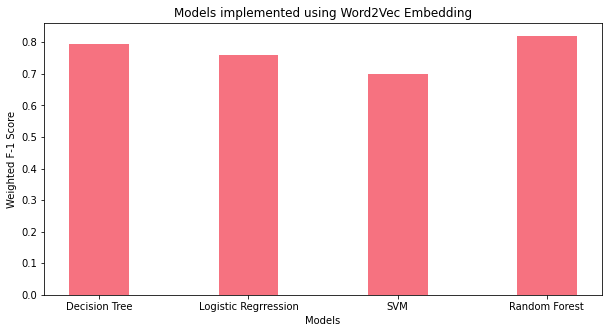

In [8]:
scores = [0.794, 0.760, 0.698, 0.820]
models = ['Decision Tree', 'Logistic Regrression', 'SVM', 'Random Forest']
fig = plt.figure(figsize = (10, 5))
xt = plt.subplot()
# creating the bar plot
plt.bar(models, scores, color ='#F67280', width = 0.4)
plt.xlabel("Models")
plt.ylabel("Weighted F-1 Score")
plt.title("Models implemented using Word2Vec Embedding")
plt.show()

# **M-BERT Embedding:**

In [ ]:
! pip install simpletransformers
from simpletransformers.classification import ClassificationModel
from transformers import AutoTokenizer

In [ ]:
x = df['sentence']
def bertEncoding():
  tokenizer = AutoTokenizer.from_pretrained('monsoon-nlp/hindi-bert')
  total_encode=[]
  unique_encode=set()
  for i in x:
    tmp=tokenizer.encode(i)
    total_encode.append(tmp)
    for i in tmp:
      unique_encode.add(i)
  unique_encode=list(unique_encode)
  unique_encode.sort()
  arr=np.zeros((8192,15188))
  new_df=pd.DataFrame(arr,columns=unique_encode)
  for k in range(0,8192):
    for i in total_encode[k]:
      new_df.at[k, i] = 1
  return new_df

In [ ]:
new_df=bertEncoding()

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=10)
pca.fit(new_df)
temp_df = pca.transform(new_df)

In [ ]:
y_mbert = df[['hate', 'offensive', 'non-hostile', 'defamation', 'fake']]
X_train, X_test, y_train, y_test = train_test_split(temp_df, y_mbert, test_size=0.20,random_state=40)

**Decision Tree Classifier:**

In [ ]:
from sklearn.tree import DecisionTreeClassifier
for l in label:
  clf = DecisionTreeClassifier(class_weight='balanced', max_depth = 20, criterion='gini').fit(X_train, y_train[l])
  pred=clf.predict(X_test)
  print("The model accuracy for class ",l)
  print(classification_report(pred,y_test[l]))

The model accuracy for class  hate
              precision    recall  f1-score   support

           0       0.84      0.91      0.88      1324
           1       0.44      0.30      0.35       315

    accuracy                           0.79      1639
   macro avg       0.64      0.60      0.62      1639
weighted avg       0.77      0.79      0.78      1639

The model accuracy for class  offensive
              precision    recall  f1-score   support

           0       0.88      0.92      0.90      1363
           1       0.49      0.36      0.41       276

    accuracy                           0.83      1639
   macro avg       0.68      0.64      0.65      1639
weighted avg       0.81      0.83      0.82      1639

The model accuracy for class  non-hostile
              precision    recall  f1-score   support

           0       0.72      0.71      0.72       770
           1       0.75      0.76      0.75       869

    accuracy                           0.74      1639
   macro av

**Logistic Regression:**

In [ ]:
from sklearn.linear_model import LogisticRegression
for l in label:
  clf = LogisticRegression(class_weight='balanced',penalty='l2',solver='liblinear').fit(X_train, y_train[l])
  pred=clf.predict(X_test)
  print("The model accuracy for class ",l)
  print(classification_report(pred,y_test[l]))

The model accuracy for class  hate
              precision    recall  f1-score   support

           0       0.76      0.93      0.84      1167
           1       0.61      0.28      0.38       472

    accuracy                           0.74      1639
   macro avg       0.69      0.60      0.61      1639
weighted avg       0.72      0.74      0.71      1639

The model accuracy for class  offensive
              precision    recall  f1-score   support

           0       0.78      0.94      0.85      1188
           1       0.64      0.29      0.40       451

    accuracy                           0.76      1639
   macro avg       0.71      0.61      0.62      1639
weighted avg       0.74      0.76      0.72      1639

The model accuracy for class  non-hostile
              precision    recall  f1-score   support

           0       0.69      0.72      0.70       725
           1       0.77      0.74      0.75       914

    accuracy                           0.73      1639
   macro av

**SVM:**

In [ ]:
label=['hate', 'offensive', 'non-hostile', 'defamation', 'fake']
from sklearn import svm
for l in label:
  clf = svm.SVC(kernel='rbf',C=0.01,gamma=1,class_weight='balanced')
  clf.fit(X_train, y_train[l])
  pred=clf.predict(X_test)
  print("The model accuracy for class ",l)
  print(classification_report(pred,y_test[l]))

The model accuracy for class  hate
              precision    recall  f1-score   support

           0       0.73      0.92      0.81      1119
           1       0.60      0.25      0.35       520

    accuracy                           0.71      1639
   macro avg       0.67      0.59      0.58      1639
weighted avg       0.69      0.71      0.67      1639

The model accuracy for class  offensive
              precision    recall  f1-score   support

           0       0.80      0.93      0.86      1239
           1       0.54      0.28      0.37       400

    accuracy                           0.77      1639
   macro avg       0.67      0.60      0.61      1639
weighted avg       0.74      0.77      0.74      1639

The model accuracy for class  non-hostile
              precision    recall  f1-score   support

           0       0.60      0.72      0.65       634
           1       0.80      0.70      0.74      1005

    accuracy                           0.71      1639
   macro av

**Random Forest Classifier:**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
for l in label:
  clf = RandomForestClassifier(n_estimators=400).fit(X_train, y_train[l])
  pred=clf.predict(X_test)
  print("The model accuracy for class ",l)
  print(classification_report(pred,y_test[l]))

The model accuracy for class  hate
              precision    recall  f1-score   support

           0       0.98      0.88      0.93      1589
           1       0.11      0.48      0.18        50

    accuracy                           0.87      1639
   macro avg       0.55      0.68      0.55      1639
weighted avg       0.96      0.87      0.91      1639

The model accuracy for class  offensive
              precision    recall  f1-score   support

           0       0.98      0.90      0.94      1557
           1       0.25      0.61      0.35        82

    accuracy                           0.89      1639
   macro avg       0.61      0.76      0.65      1639
weighted avg       0.94      0.89      0.91      1639

The model accuracy for class  non-hostile
              precision    recall  f1-score   support

           0       0.76      0.79      0.77       734
           1       0.82      0.80      0.81       905

    accuracy                           0.79      1639
   macro av

**Multi Level Perceptron:**

In [ ]:
from sklearn.neural_network import MLPClassifier
for l in label:
  clf = MLPClassifier(hidden_layer_sizes=50,activation='logistic').fit(X_train, y_train[l])
  pred=clf.predict(X_test)
  print("The model accuracy for class ",l)
  print(classification_report(pred,y_test[l]))

The model accuracy for class  hate
              precision    recall  f1-score   support

           0       0.98      0.88      0.93      1591
           1       0.10      0.46      0.17        48

    accuracy                           0.87      1639
   macro avg       0.54      0.67      0.55      1639
weighted avg       0.96      0.87      0.91      1639

The model accuracy for class  offensive
              precision    recall  f1-score   support

           0       0.99      0.89      0.94      1602
           1       0.11      0.62      0.19        37

    accuracy                           0.88      1639
   macro avg       0.55      0.75      0.56      1639
weighted avg       0.97      0.88      0.92      1639

The model accuracy for class  non-hostile
              precision    recall  f1-score   support

           0       0.65      0.73      0.69       671
           1       0.79      0.72      0.76       968

    accuracy                           0.73      1639
   macro av

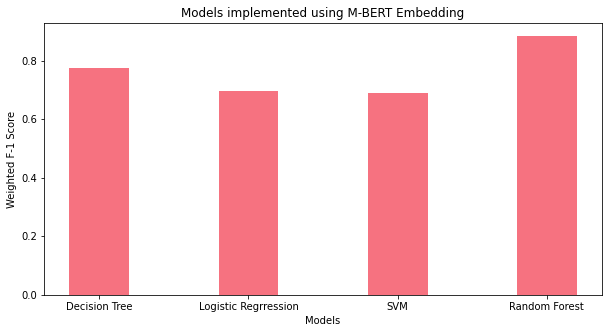

In [10]:
scores = [0.776, 0.696, 0.688, 0.884]  
models = ['Decision Tree', 'Logistic Regrression', 'SVM', 'Random Forest']
fig = plt.figure(figsize = (10, 5))
xt = plt.subplot()
# creating the bar plot
plt.bar(models, scores, color ='#F67280', width = 0.4)
plt.xlabel("Models")
plt.ylabel("Weighted F-1 Score")
plt.title("Models implemented using M-BERT Embedding")
plt.show()

# **LSTM:**

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D


In [ ]:
def LSTM_algo():
  tokenizer = Tokenizer(num_words=1000, split=' ') 
  tokenizer.fit_on_texts(df['sentence'].values)
  X = tokenizer.texts_to_sequences(df['sentence'].values)
  X = pad_sequences(X)
  model = Sequential()
  model.add(Embedding(1000, 120, input_length = X.shape[1]))
  model.add(SpatialDropout1D(0.4))
  model.add(LSTM(176, dropout=0.5, recurrent_dropout=0.2))
  model.add(Dense(1,activation='sigmoid'))
  model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['accuracy'] )
  print(model.summary())
  y = df[['hate', 'offensive', 'non-hostile', 'defamation', 'fake']]
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y)
  batch_size=32
  labels=['hate', 'offensive', 'non-hostile', 'defamation', 'fake']
  for l in labels:
      print('** {} ...tweets...**'.format(l))   
      model.fit(X_train, y_train[l], epochs = 2, batch_size = batch_size, verbose = 'auto')  
      model.evaluate(X_test,y_test[l])
      # y_pred = model.predict(X_test)
      # pred = np.argmax(y_pred, axis=1)
      # print(classification_report(y_test[l], pred))
      # precision = precision_score(y_test[l], pred, average='weighted')
      # recall = recall_score(y_test[l], pred, average='weighted')
      # f1 = f1_score(y_test[l], pred, average='weighted')
      # acc = accuracy_score(y_test[l], pred)
      # print("\n Precision: {:.4f}, Recall: {:.4f}, Weighted F1-measure: {:.4f}, Accuracy: {:.4f}\n".format(precision, recall, f1, acc))




In [ ]:
LSTM_algo()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 93, 120)           120000    
                                                                 
 spatial_dropout1d_8 (Spatia  (None, 93, 120)          0         
 lDropout1D)                                                     
                                                                 
 lstm_8 (LSTM)               (None, 176)               209088    
                                                                 
 dense_8 (Dense)             (None, 1)                 177       
                                                                 
Total params: 329,265
Trainable params: 329,265
Non-trainable params: 0
_________________________________________________________________
None
** hate ...tweets...**
Epoch 1/2
192/192 [==============================] - 88s 443ms/step - loss: 0.0000e+00

**Bi-Directional LSTM:**

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
def BiDirectionalLstm():
  max_features = 30000  # Only consider the top 20k words
  maxlen = 200  
  inputs = keras.Input(shape=(None,), dtype="int32")
  # Embed each integer in a 128-dimensional vector
  x = layers.Embedding(max_features, 128)(inputs)
  # Add 2 bidirectional LSTMs
  x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
  x = layers.Bidirectional(layers.LSTM(64))(x)
  # Add a classifier
  outputs = layers.Dense(1, activation="sigmoid")(x)
  model = keras.Model(inputs, outputs)
  model.summary()
  tokenizer = Tokenizer(num_words=2000, split=' ') 
  tokenizer.fit_on_texts(df['sentence'].values)
  X = tokenizer.texts_to_sequences(df['sentence'].values)
  X = pad_sequences(X)
  y = df[['hate', 'offensive', 'non-hostile', 'defamation', 'fake']]
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y)

  # x_train = keras.preprocessing.sequence.pad_sequences(X_train, maxlen=maxlen)
  # x_val = keras.preprocessing.sequence.pad_sequences(X_test, maxlen=maxlen)
  model.compile("adam", "binary_crossentropy", metrics=["accuracy"])
  batch_size=32
  labels=['hate', 'offensive', 'non-hostile', 'defamation', 'fake']
  for l in labels:
    print('**...{} tweets...** '.format(l))   
    model.fit(X_train, y_train[l], epochs = 3, batch_size = batch_size, verbose = 'auto')  
    model.evaluate(X_test,y_test[l])
    # y_pred = model.predict(X_test)
    # pred = np.argmax(y_pred, axis=1)
    # precision = precision_score(y_test[l], pred, average='weighted')
    # recall = recall_score(y_test[l], pred, average='weighted')
    # f1 = f1_score(y_test[l], pred, average='weighted')
    # acc = accuracy_score(y_test[l], pred)
    # print("\n Precision: {:.4f}, Recall: {:.4f}, Weighted F1-measure: {:.4f}, Accuracy: {:.4f}\n".format(precision, recall, f1, acc))








In [ ]:
BiDirectionalLstm()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_4 (Embedding)     (None, None, 128)         3840000   
                                                                 
 bidirectional_8 (Bidirectio  (None, None, 128)        98816     
 nal)                                                            
                                                                 
 bidirectional_9 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 1)                 129       
                                                                 
Total params: 4,037,761
Trainable params: 4,037,761
Non-tra